In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt

# Load dataset
student_data = pd.read_csv("synthetic_student_data.csv")

In [2]:
student_data.head()

,StudentID,Academic_Performance,isolated,WomenDifferent,language,COVID,criticises,MenBetterSTEM,pwi_wellbeing,Intelligence1,...,k6_4,k6_5,k6_6,Manbox5_overall,Masculinity_contrained,GrowthMindset,k6_overall,School_support_engage,Friends,Friends_Count
0,S0001,61,3,4,0,4,1,2,8,6,...,1,1,1,2.2,3.75,2.5,7,4.50,"S0260, S0282, S0993, S0955, S0724",5
1,S0002,53,6,5,1,4,4,2,1,5,...,5,1,1,5.4,3.75,5.0,17,4.00,"S0480, S0819, S0325",3
2,S0003,62,3,6,0,2,1,3,0,3,...,1,3,1,4.0,4.00,5.5,15,4.75,"S0356, S0942, S0978, S0556",4
3,S0004,96,3,2,1,2,2,2,0,1,...,3,4,2,2.0,3.25,5.0,19,2.75,"S0725, S0124, S0879, S0177, S0738, S0648, S0105",7
4,S0005,68,5,6,0,7,2,7,3,4,...,2,2,5,4.0,4.75,3.0,18,4.75,"S0627, S0454, S0098, S0028",4


In [3]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   StudentID               1000 non-null   object 
 1   Academic_Performance    1000 non-null   int64  
 2   isolated                1000 non-null   int64  
 3   WomenDifferent          1000 non-null   int64  
 4   language                1000 non-null   int64  
 5   COVID                   1000 non-null   int64  
 6   criticises              1000 non-null   int64  
 7   MenBetterSTEM           1000 non-null   int64  
 8   pwi_wellbeing           1000 non-null   int64  
 9   Intelligence1           1000 non-null   int64  
 10  Intelligence2           1000 non-null   int64  
 11  Soft                    1000 non-null   int64  
 12  opinion                 1000 non-null   int64  
 13  Nerds                   1000 non-null   int64  
 14  comfortable             1000 non-null   i

In [4]:
# Step 1: Check for missing values
student_data.isnull().sum()

StudentID                   0
Academic_Performance        0
isolated                    0
WomenDifferent              0
language                    0
COVID                       0
criticises                  0
MenBetterSTEM               0
pwi_wellbeing               0
Intelligence1               0
Intelligence2               0
Soft                        0
opinion                     0
Nerds                       0
comfortable                 0
future                      0
bullying                    0
Manbox5_1                   0
Manbox5_2                   0
Manbox5_3                   0
Manbox5_4                   0
Manbox5_5                   0
k6_1                        0
k6_2                        0
k6_3                        0
k6_4                        0
k6_5                        0
k6_6                        0
Manbox5_overall             0
Masculinity_contrained      0
GrowthMindset               0
k6_overall                  0
School_support_engage       0
Friends   

In [5]:
# Clean the 'Friends' column safely
student_data['Friends'] = student_data['Friends'].fillna('')  # Fill NaN with empty string

# Convert to list only if it's a string
student_data['Friends'] = student_data['Friends'].apply(
    lambda x: [] if x == '' else (x if isinstance(x, list) else x.split(','))
)

In [6]:
# Check for dulicate values
student_data_no_friends = student_data.drop(columns=['Friends'])
duplicate_rows = student_data[student_data_no_friends.duplicated()]
print(f"Duplicate rows found (excluding 'Friends'): {len(duplicate_rows)}")

duplicate_ids = student_data[student_data.duplicated(subset='StudentID')]
print(f"Duplicate StudentIDs found: {len(duplicate_ids)}")

Duplicate rows found (excluding 'Friends'): 0
Duplicate StudentIDs found: 0


In [7]:
# Check basic statistical summary to find outliers or weird values
student_data.describe()

,Academic_Performance,isolated,WomenDifferent,language,COVID,criticises,MenBetterSTEM,pwi_wellbeing,Intelligence1,Intelligence2,...,k6_3,k6_4,k6_5,k6_6,Manbox5_overall,Masculinity_contrained,GrowthMindset,k6_overall,School_support_engage,Friends_Count
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,70.360000,3.965000,3.973000,0.222000,3.992000,3.96500,4.073000,4.865000,3.95900,3.952000,...,3.002000,2.855000,3.012000,3.023000,4.004600,4.00950,4.044500,17.830000,3.986500,3.504000
std,14.478053,2.037136,1.924571,0.415799,1.979863,1.99744,1.987365,3.167777,2.00033,1.983338,...,1.376914,1.401406,1.376136,1.436849,0.900505,1.00208,1.436431,3.482704,1.019918,2.308097
min,23.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.000000,0.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.400000,1.25000,1.000000,7.000000,1.000000,0.000000
25%,60.000000,2.000000,2.000000,0.000000,2.000000,2.00000,2.000000,2.000000,2.00000,2.000000,...,2.000000,2.000000,2.000000,2.000000,3.400000,3.25000,3.000000,16.000000,3.250000,1.000000
50%,70.000000,4.000000,4.000000,0.000000,4.000000,4.00000,4.000000,5.000000,4.00000,4.000000,...,3.000000,3.000000,3.000000,3.000000,4.000000,4.00000,4.000000,18.000000,4.000000,3.000000
75%,80.000000,6.000000,6.000000,0.000000,6.000000,6.00000,6.000000,7.000000,6.00000,6.000000,...,4.000000,4.000000,4.000000,4.000000,4.600000,4.75000,5.000000,20.000000,4.750000,6.000000
max,100.000000,7.000000,7.000000,1.000000,7.000000,7.00000,7.000000,10.000000,7.00000,7.000000,...,5.000000,5.000000,5.000000,5.000000,7.000000,6.75000,7.000000,28.000000,7.000000,7.000000


In [8]:
# Create the required fields
processed_data = student_data.copy()

# Create the fields
processed_data['Wellbeing_Score'] = processed_data['pwi_wellbeing']
processed_data['Friendliness_Score'] = processed_data['School_support_engage']
processed_data['Bullying_Score'] = processed_data['criticises']
processed_data['Composite_Score'] = (
    0.5 * processed_data['Academic_Performance'] +
    0.3 * processed_data['Wellbeing_Score'] +
    0.2 * processed_data['Friendliness_Score']
)
processed_data['Is_Bully'] = processed_data['Bullying_Score'] >= 5

# Show the first few rows to confirm
processed_data[['StudentID', 'Academic_Performance', 'Wellbeing_Score', 
                'Friendliness_Score', 'Bullying_Score', 'Composite_Score', 'Is_Bully']].head()

,StudentID,Academic_Performance,Wellbeing_Score,Friendliness_Score,Bullying_Score,Composite_Score,Is_Bully
0,S0001,61,8,4.50,1,33.80,False
1,S0002,53,1,4.00,4,27.60,False
2,S0003,62,0,4.75,1,31.95,False
3,S0004,96,0,2.75,2,48.55,False
4,S0005,68,3,4.75,2,35.85,False


In [9]:
# Import Libraries
import pandas as pd
import numpy as np
import random
from ortools.sat.python import cp_model
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict

# Load Dataset
df = pd.read_csv("synthetic_student_data.csv")
df['Isolation_Score'] = 7 - df['isolated']
df['COVID_Score'] = 7 - df['COVID']
df['Wellbeing_Score'] = (df['pwi_wellbeing'] + df['Isolation_Score'] + df['COVID_Score']) / 3
df['Bullying_Score'] = df['criticises']
df['Friendliness_Score'] = df['School_support_engage']
df['Student_Index'] = range(len(df))

student_data = df[['Student_Index', 'Academic_Performance', 'Wellbeing_Score', 
                   'Bullying_Score', 'Friendliness_Score', 'language']]
num_students = len(student_data)


# CP-SAT Model Setup
model = cp_model.CpModel()
class_size_limit = 25
num_classes = 40

student_vars = []
for i in range(num_students):
    var = model.NewIntVar(0, num_classes - 1, f'student_{i}_class')
    student_vars.append(var)

class_students = defaultdict(list)
for idx, var in enumerate(student_vars):
    for cls in range(num_classes):
        is_in_class = model.NewBoolVar(f'student_{idx}_is_in_class_{cls}')
        model.Add(var == cls).OnlyEnforceIf(is_in_class)
        model.Add(var != cls).OnlyEnforceIf(is_in_class.Not())
        class_students[cls].append(is_in_class)

# Constraints
for i in range(num_students):
    model.Add(sum(class_students[cls][i] for cls in range(num_classes)) == 1)
for cls in range(num_classes):
    model.Add(sum(class_students[cls]) == class_size_limit)

# Academic Balance Constraint (total score diff)
max_allowed_difference = 20
class_academic_scores = {}
for cls in range(num_classes):
    total_academic = sum(int(student_data.loc[idx, 'Academic_Performance']) * class_students[cls][idx]
                         for idx in range(num_students))
    class_academic_scores[cls] = total_academic

for i in range(num_classes):
    for j in range(i + 1, num_classes):
        diff = model.NewIntVar(0, 10000, f'diff_{i}_{j}')
        model.AddAbsEquality(diff, class_academic_scores[i] - class_academic_scores[j])
        model.Add(diff <= max_allowed_difference * class_size_limit)

# Wellbeing Constraint
max_allowed_wellbeing_diff = 3
class_wellbeing_scores = {}
for cls in range(num_classes):
    total_wellbeing = sum(int(student_data.loc[idx, 'Wellbeing_Score']) * class_students[cls][idx]
                          for idx in range(num_students))
    class_wellbeing_scores[cls] = total_wellbeing

for i in range(num_classes):
    for j in range(i + 1, num_classes):
        diff = model.NewIntVar(0, 10000, f'wellbeing_diff_{i}_{j}')
        model.AddAbsEquality(diff, class_wellbeing_scores[i] - class_wellbeing_scores[j])
        model.Add(diff <= max_allowed_wellbeing_diff * class_size_limit)

# Bully Spread Constraint
max_bullies_per_class = 4
for cls in range(num_classes):
    bully_vars = [class_students[cls][idx] for idx in range(num_students)
                  if student_data.loc[idx, 'Bullying_Score'] >= 7]
    model.Add(sum(bully_vars) <= max_bullies_per_class)

# Solve CP Model
solver = cp_model.CpSolver()
print(f"Max bullies allowed: {max_bullies_per_class * num_classes}")
status = solver.Solve(model)

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print("CP-SAT solution found.")
else:
    raise RuntimeError("No feasible CP-SAT solution found.")


# Extract CP-SAT Result
student_assignments = []
for i in range(num_students):
    assigned_class = solver.Value(student_vars[i])
    student_assignments.append({
        'StudentID': student_data.iloc[i]['Student_Index'],
        'Assigned_Class': assigned_class
    })

assignments_df = pd.DataFrame(student_assignments)
student_data_with_class = student_data.copy()
student_data_with_class['Assigned_Class'] = assignments_df['Assigned_Class']
student_data_with_class['Is_Bully'] = student_data_with_class['Bullying_Score'] >= 7


Max bullies allowed: 160
CP-SAT solution found.


In [10]:
class StudentAssignmentEnv:
    def __init__(self, students_df, n_classes=40, initial_assignment=None, max_steps=500):
        self.students = students_df.copy()
        self.n_classes = n_classes
        self.max_steps = max_steps
        self.steps_taken = 0
        self.classrooms = {f"Class_{i}": [] for i in range(n_classes)}

        if initial_assignment is not None:
            for _, row in self.students.iterrows():
                assigned_class = int(row['Assigned_Class'])
                self.classrooms[f"Class_{assigned_class}"].append(row['Student_Index'])
            self.unassigned_students = []
        else:
            self.unassigned_students = self.students.index.tolist()

    def reset(self):
        self.steps_taken = 0
        return self._get_state()

    def _get_state(self):
        return {
            'classroom_sizes': [len(cls) for cls in self.classrooms.values()],
            'unassigned': self.unassigned_students.copy()
        }

    def step(self, action):
        student_idx, new_class = action

        # If student already in that class, skip
        for cls_id, students in self.classrooms.items():
            if student_idx in students:
                if cls_id == f"Class_{new_class}":
                    self.steps_taken += 1
                    return self._get_state(), 0, self.steps_taken >= self.max_steps, {}
                students.remove(student_idx)
                break

        self.classrooms[f"Class_{new_class}"].append(student_idx)
        self.steps_taken += 1
        done = self.steps_taken >= self.max_steps

        reward, academic_std, wellbeing_std, bullying_penalty = self._calculate_reward()

        info = {
            'academic_std': academic_std,
            'wellbeing_std': wellbeing_std,
            'bullying_penalty': bullying_penalty
        }

        return self._get_state(), reward, done, info

    def _calculate_reward(self):
        academic_scores, wellbeing_scores, bullying_risks = [], [], []
        total_students = sum(len(cls) for cls in self.classrooms.values())
        for cls_indices in self.classrooms.values():
            if not cls_indices:
                continue
            cls_students = self.students.loc[cls_indices]
            sampled_students = cls_students.sample(n=min(20, len(cls_students)))
            academic_scores.append(sampled_students['Academic_Performance'].mean())
            wellbeing_scores.append(sampled_students['Wellbeing_Score'].mean())
            bullying_risks.append(cls_students['Is_Bully'].sum())

        academic_std = np.std(academic_scores)
        wellbeing_std = np.std(wellbeing_scores)
        bullying_penalty = sum(bullying_risks) / max(total_students, 1)
        academic_std = min(academic_std, 10)
        wellbeing_std = min(wellbeing_std, 5)

        reward = -((academic_std / 100) + (wellbeing_std / 10) + bullying_penalty)
        return reward, academic_std, wellbeing_std, bullying_penalty


Episode 1 completed. Steps: 484 | Reward: -539.81
Episode 2 completed. Steps: 490 | Reward: -523.05
Episode 3 completed. Steps: 482 | Reward: -536.18
Episode 4 completed. Steps: 488 | Reward: -554.98
Episode 5 completed. Steps: 491 | Reward: -567.56
Episode 6 completed. Steps: 492 | Reward: -532.95
Episode 7 completed. Steps: 487 | Reward: -517.39
Episode 8 completed. Steps: 484 | Reward: -534.13
Episode 9 completed. Steps: 493 | Reward: -520.22
Episode 10 completed. Steps: 492 | Reward: -524.69
Episode 10:
  Total Normalized Reward: -524.69
  Academic Std Deviation: 3.26
  Wellbeing Std Deviation: 0.35
  Bullying Penalty: 0.1300
----------------------------------------
Episode 11 completed. Steps: 488 | Reward: -529.68
Episode 12 completed. Steps: 492 | Reward: -533.22
Episode 13 completed. Steps: 486 | Reward: -546.99
Episode 14 completed. Steps: 485 | Reward: -525.48
Episode 15 completed. Steps: 492 | Reward: -502.36
Episode 16 completed. Steps: 488 | Reward: -527.07
Episode 17 comp

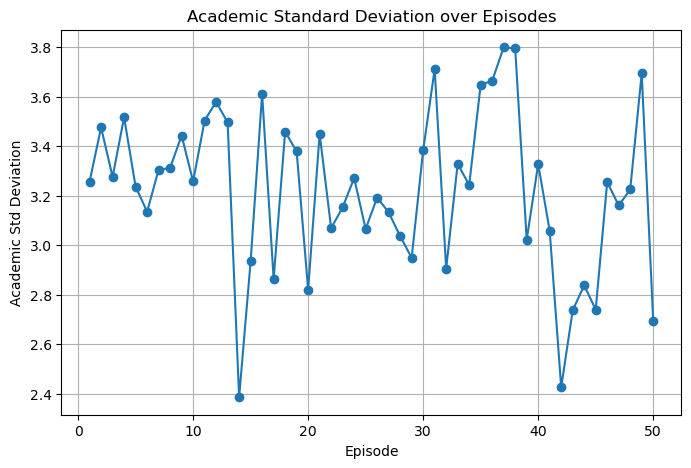

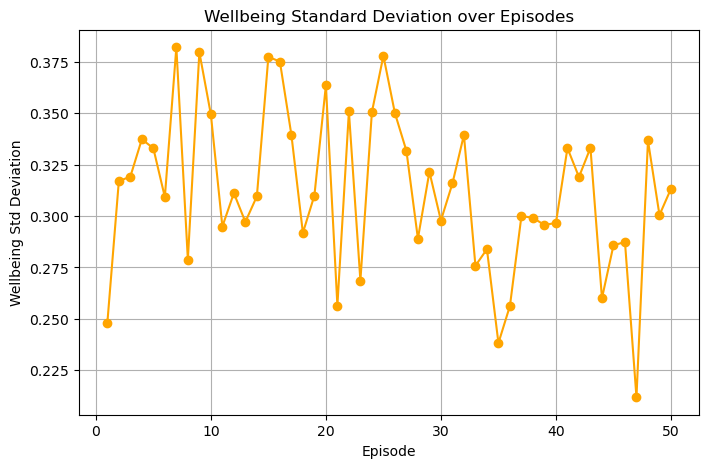

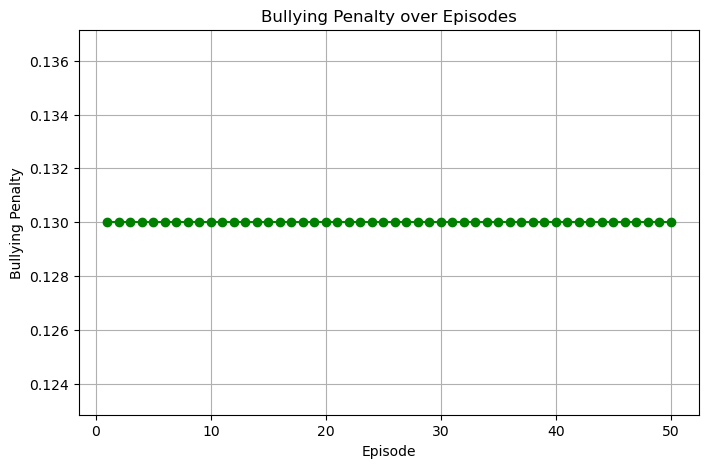

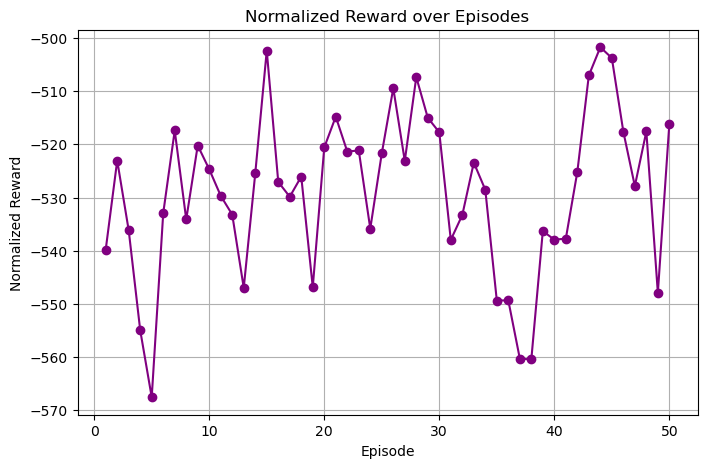

In [11]:
# Define DQN Model
class DQNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define DQN Agent

class DQNAgent:
    def __init__(self, input_dim, output_dim, lr=0.001, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.model = DQNModel(input_dim, output_dim)
        self.target_model = DQNModel(input_dim, output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.output_dim = output_dim

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.output_dim - 1)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def train_step(self, state, action, reward, next_state, done):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        reward_tensor = torch.FloatTensor([reward])
        action_tensor = torch.LongTensor([action])

        q_value = self.model(state_tensor).gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        next_q_value = self.target_model(next_state_tensor).max(1)[0]
        expected_q_value = reward_tensor + (1 - int(done)) * self.gamma * next_q_value

        loss = self.criterion(q_value, expected_q_value.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# ----------------------------------
# 4. Hybrid Setup: Load CP-SAT Output into RL Environment
# ----------------------------------
def make_hybrid_env():
    return StudentAssignmentEnv(student_data_with_class, initial_assignment=student_data_with_class)

env = make_hybrid_env()

# ----------------------------------
# 5. Train the DQN Agent
# ----------------------------------
n_episodes = 50

# Define action space: (student_idx, new_class) → num_students * num_classes
num_students = len(student_data_with_class)
num_classes = 40
action_space_size = num_students * num_classes

input_dim = num_classes  # Using normalized classroom sizes as state
agent = DQNAgent(input_dim=input_dim, output_dim=action_space_size, epsilon_min=0.01)

academic_stds = []
wellbeing_stds = []
bullying_penalties = []
normalized_rewards = []

for episode in range(n_episodes):
    state_data = env.reset()
    total_custom_reward = 0
    done = False
    steps = 0

    academic_std_episode = 0
    wellbeing_std_episode = 0
    bullying_penalty_episode = 0

    while not done:
        classroom_sizes = np.array(state_data['classroom_sizes']) / 1000  # Normalize

        # Agent selects a (student, new_class) action encoded as a flat index
        action_index = agent.choose_action(classroom_sizes)
        student_idx = action_index // num_classes
        target_class = action_index % num_classes

        next_state_data, reward, done, info = env.step((student_idx, target_class))

        # If step did nothing (student already in class), skip
        if not info:
            continue
        next_classroom_sizes = np.array(next_state_data['classroom_sizes']) / 1000

        # Compute custom reward
        custom_reward = (
            0.7 * (1 - min(info['academic_std'], 5) / 10) +
            0.2 * (1 - info['wellbeing_std'] / 10) +
            0.1 * (1 - info['bullying_penalty'] * 100)
        )

        # Training
        agent.train_step(classroom_sizes, action_index, custom_reward, next_classroom_sizes, done)

        total_custom_reward += custom_reward
        state_data = next_state_data
        steps += 1

        academic_std_episode = info['academic_std']
        wellbeing_std_episode = info['wellbeing_std']
        bullying_penalty_episode = info['bullying_penalty']

    
    # Log metrics
    normalized_reward = (total_custom_reward / steps) * 1000
    normalized_rewards.append(normalized_reward)
    academic_stds.append(academic_std_episode)
    wellbeing_stds.append(wellbeing_std_episode)
    bullying_penalties.append(bullying_penalty_episode)

    agent.decay_epsilon()
    print(f"Episode {episode + 1} completed. Steps: {steps} | Reward: {normalized_reward:.2f}")

    if (episode + 1) % 10 == 0:
        agent.update_target()
        print(f"Episode {episode + 1}:")
        print(f"  Total Normalized Reward: {normalized_reward:.2f}")
        print(f"  Academic Std Deviation: {academic_std_episode:.2f}")
        print(f"  Wellbeing Std Deviation: {wellbeing_std_episode:.2f}")
        print(f"  Bullying Penalty: {bullying_penalty_episode:.4f}")
        print("-" * 40)

# ----------------------------------
# 6. Plotting Results
# ----------------------------------

episodes = np.arange(1, n_episodes + 1)

plt.figure(figsize=(8, 5))
plt.plot(episodes, academic_stds, marker='o')
plt.title('Academic Standard Deviation over Episodes')
plt.xlabel('Episode')
plt.ylabel('Academic Std Deviation')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(episodes, wellbeing_stds, marker='o', color='orange')
plt.title('Wellbeing Standard Deviation over Episodes')
plt.xlabel('Episode')
plt.ylabel('Wellbeing Std Deviation')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(episodes, bullying_penalties, marker='o', color='green')
plt.title('Bullying Penalty over Episodes')
plt.xlabel('Episode')
plt.ylabel('Bullying Penalty')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(episodes, normalized_rewards, marker='o', color='purple')
plt.title('Normalized Reward over Episodes')
plt.xlabel('Episode')
plt.ylabel('Normalized Reward')
plt.grid(True)
plt.show()
